# imgtofmri

imgtofmri is a python package that predicts fMRI activity from individual visual frames. We are publicly releasing this package to aid research investigations into how brain responses are driven from individual visual frames of movies. 

###### (Process memory):

Neuroscience research often investigates how humans are able to adeptly process continuous streams of immense perceptual data. Previous research focused on models of working memory that drew analogies from computer systems and described retrieval of memory from 'memory stores', such as those from a harddrive, where past information could be integrated with present input in a sort of 'buffer'. These theories, however, rely on several distinct memory components (psuedo-CPU, RAM, etc.) that have not been identified in the brain, and in fact, the neural regions often identified as the working memory 'buffers' are the same circuits that perform actual perceptual processing [[5 from Hasson]]. As a result of these challenges, more recent theories such as [[Hasson et al. 2015](http://dx.doi.org/10.1016/j.tics.2015.04.006)] postulate that the processing of current input should not be considered separate from working memory traces of past information. Instead, the 'process memory' framework posits that a brain's response to current input is dependent not only on that sensory input but also on past stimulus, at varying timescales. These varying timescales, defined empirically through fMRI and ECoG experiments with scrambled perceptual input at varying scales (e.g. shuffling phonemes, words, sentences, paragraphs, etc), explain how sensory regions have shorter temporal receptive windows (TRW) on the order of milliseconds (e.g. to process phonemes), wheras higher order regions have TRW on the order of seconds to minutes (e.g. to process a long sentence or paragraph). In this manner, process memory provides a framework for describing how the brain continuously integrates perceptual data with recent contextual information over varying timescales.


<!-- % have to motivate why f-f predictions are interesting to study.. this is a way to think ab movie responses. 
 -->
###### (Event boundary background):
Process memory research, also extends well to the event segmentation literature, which similarly investigates how humans segment a constant stream of perceptual input into discrete events of varying timescales [[Zacks, Tversky 2001](http://dx.doi.org/10.1037//0033-2909.127.1.3)]. Research in this area has shown that these discrete events can be identified from cortical activity patterns [[Baldassano et al. 2017](https://doi.org/10.1016/j.neuron.2017.06.041)] and the timescales of these events varies along a cortical hierarchy, with higher-order brain regions such as the posterior medial cortex showing larger timescales for events than sensory or early-visual regions. Movies are commonly used for studying this type of naturalistic perception with an fMRI scanner, and as such, previous research has also focused on decoding semantic content from natural movies [[Huth et al. 2016](https://doi.org/10.3389/fnsys.2016.00081)]. However, many questions remain about the timescale of events in these various brain regions, and about the extent to which these timescales can be predicted.


Furthermore, given that neural circuits process both current perceptual information as well as past information, we would like to know what activity, at a given point of time, can be predicted solely based on current perceptual input. If we can better model cortical responses to current stimulus, disentangled from recent or past stimuli, we might better focus our attention to how cortical circuits integrate recent stimulus to process the present, separate from any specific present stimulus. Thus, considering silent movies, if we can predict cortical responses to each frame of a movie, we might compare this expected stimulus-driven activity to humans actually watching that movie, and see what responses are driven purely based on the current stimulus.

<!-- (more on modeling/prediction of events) -- [[Reynolds 2010](https://doi.org/10.1080/15326900701399913)], [[Shin, Dubrow 2020](https://doi.org/10.1111/tops.12505)] -->


###### (DNNs as feature extractors for neural prediction):


In recent years, artificial deep neural networks (DNNs) have shown promise in predicting cortical responses in the human visual cortex when trained on real world categorization tasks [[Cichy et al. 2016](https://doi.org/10.1038/srep27755)]. These neural networks learn to extract features (e.g. shapes, textures, eyes) from naturalistic visual data that allow them to accurately classify objects, animals, and scenes in the images they process [[Olah et al. 2017](https://distill.pub/2017/feature-visualization/)]. In the context of neuroscience, these networks can be used to extract predominant features from input which can then be used to predict brain responses along a cortical processing hierarchy [[Eickenberg et al. 2017](https://doi.org/10.1016/j.neuroimage.2016.10.001)]. Research has also shown that the hierarchy of layers in a DNN can predict along a hierarchy of processing in the brain, where deeper, or higher, layers in a DNN best predict higher levels of cortical processing [[Kell et al. 2018](https://doi.org/10.1016/j.neuron.2018.03.044)]. Using DNNs for feature extraction and brain prediction has also been shown with other modalities, such as audio and language data [cite Huth] as well as  cross-modal audiovisual data [[Khosla et al. 2021](https://doi.org/10.1126/sciadv.abe7547)].

<!-- (related tools? Brain-Score?) -->


###### (Model introduction):
In this notebook, we present imgtofmri, a python package and model that allows for quick predictions of group-averaged cortical responses to visual stimuli. As we outline in this notebook, we can use this model to predict brain responses to unseen images, or to more continuous, naturalistic stimuli such as movies. With an unseen dataset, twinset[cite], we show how our model can predict brain responses to various categories of visual stimulus, both within and across subjects. With movies, we focus on Pixar's Partly Cloudy[cite + also oliva's] and compare our model's frame-by-frame predictions to that of human subjects watching the same movie, showing that much of the event segmentation observed in the human brain can be explained by mid-level semantic information in the visual stimulus.


We build on this research, as well as on the open source BOLD5000 dataset and pretrained ResNet model as our CNN, to create a package for predicting group-averaged fMRI activity from images or movies.

<center>
<img src="img/overview.png" alt="drawing" width="500" align="center"/>
</center>

In this notebook, we overview use of the python and command line package, imgtofmri, as well as demonstrate the model's extension and prediction power to novel datasets not used in the training of the model.

## Using imgtofmri on an unseen dataset
We first show how we can use imgtofmri to predict fMRI responses to out-of-dataset images. We perform this on the [Twinset Dataset](http://twinsetfusion.csail.mit.edu/) compiled by Mohsenzadeh et al. This dataset is comprised of fMRI data for 33 adults viewing 156 images. These images are split across 5 categories:

<center>
<img src="img/twinset_cropped.png" alt="drawing" width="300" align="center"/>
</center>

We proceed by:
<ol>
<li>Downloading this dataset</li>
<li>Pushing it through our model with the imgtofmri.predict() function</li>
<li>Analyzing performance:</li>
    <ol>
<li>With the whole group</li>
<li>Within categories</li>
<li>Within subjects</li>
    </ol>
</ol>

In [10]:
%load_ext autoreload
%autoreload 2
import imgtofmri

In [75]:
input_dir = 'input_images/156ImageStimuliSet/'
output_dir = 'output_testing_aperture/'

# Options for ROIs are: EarlyVis, OPA, LOC, PPA, RSC
# We use LOC, PPA, and RSC for our tutorial, as they performed strongest above chance
rois = ['LOC', 'PPA', 'RSC']

In [76]:
url = 'http://wednesday.csail.mit.edu/fusion_rep/stimulus/156ImageStimuliSet.zip'
imgtofmri.load_imgs(url)

Downloaded and extracted: 156ImageStimuliSet.zip


In [3]:
imgtofmri.predict(input_dir, output_dir, rois)

Averaging MNI brains: 100%|██████████| 157/157 [00:13<00:00, 11.83it/s]


### Twinset Analyses

In [4]:
imgtofmri.twinset_generate_group_correlations(output_dir)

100%|██████████| 156/156 [07:19<00:00,  2.82s/it]


Real difference:      0.048752
Mean null difference: -0.000037
p value:              0.000100
norm.sf:              0.000000



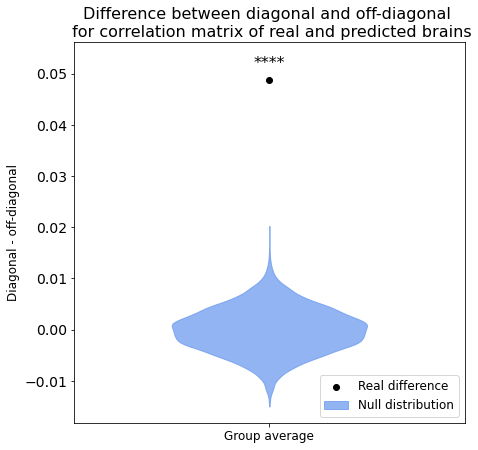

In [9]:
imgtofmri.twinset_random_group_permutations(n_shuffle=10000, print_vals=True)

In [3]:
imgtofmri.twinset_generate_category_correlations(output_dir)

Generating correlations for 'faces': 100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


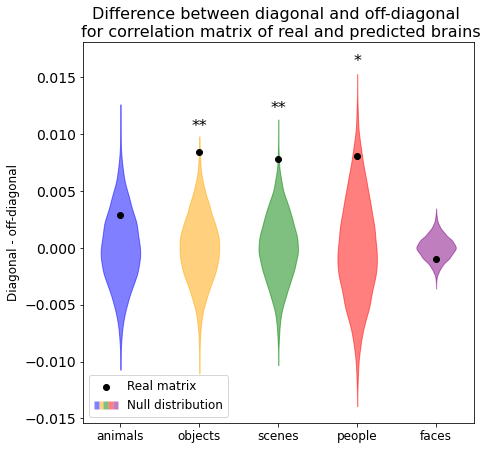

In [37]:
# imgtofmri.twinset_random_category_permutations(n_shuffle=1000, print_vals=True)
imgtofmri.twinset_random_category_permutations(n_shuffle=10000)

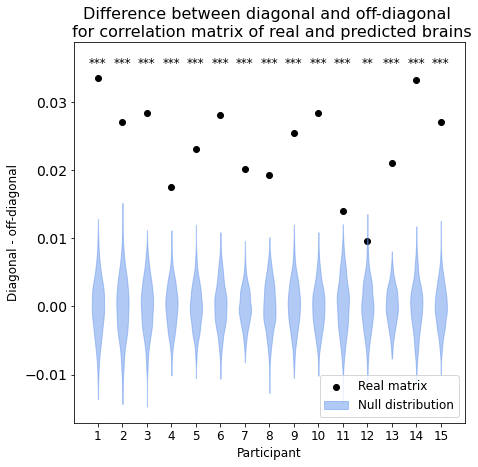

In [7]:
imgtofmri.twinset_random_participant_permutations(n_shuffle=1000)

### Generalizing image prediction to movies (Partly Cloudy)

In [1]:
from imgtofmri import *

220325-16:02:35,822 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.5.1


In [2]:
true_dir = "../pc_true/preprocessed_data"
output_dir = "output/"
input_dir = "../partly_cloudy/"
overlap = get_subj_overlap()

In [3]:
# Loading predicted brains
pred = nib.load(f'{output_dir}/pred_avg_ra_dcto.nii.gz').get_fdata()
pred = pred[:,:,:,2:-8]
pred = np.corrcoef(pred[overlap].T)
# plt.imshow(pred)

In [4]:
# Loading Luminance model as comparison
lum = get_luminance(input_dir)
lum = np.corrcoef(lum)

Downsampling: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


In [5]:
# Loading True brains
true = nib.load(f'{true_dir}/avg_r_ro_m_s_z_ra_dcto.nii.gz').get_fdata()
true = true[:,:,:,10:]
true = np.corrcoef(true[overlap].T)
# plt.imshow(true)

Text(0.5, 0.98, 'Correlation matrices for Partly Cloudy')

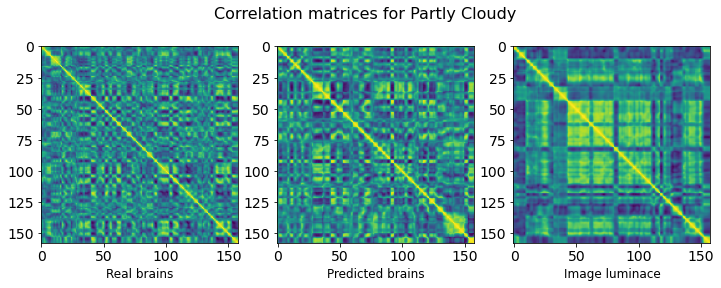

In [6]:
# Correlation matrices
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].imshow(true)
axes[1].imshow(pred)
axes[2].imshow(lum)
axes[0].set_xlabel('Real brains', fontsize=12)
axes[1].set_xlabel('Predicted brains', fontsize=12)
axes[2].set_xlabel('Image luminace', fontsize=12)
fig.suptitle('Correlation matrices for Partly Cloudy', fontsize=16)

### Comparing performance between Predicted brains + Luminance model

In [7]:
corr = generate_bootstrapped_correlations(true, pred, lum, TR_band=None)

Generating and loading bootstraps: 100%|██████████| 100/100 [05:53<00:00,  3.54s/it]


#### On the full movie timecourse

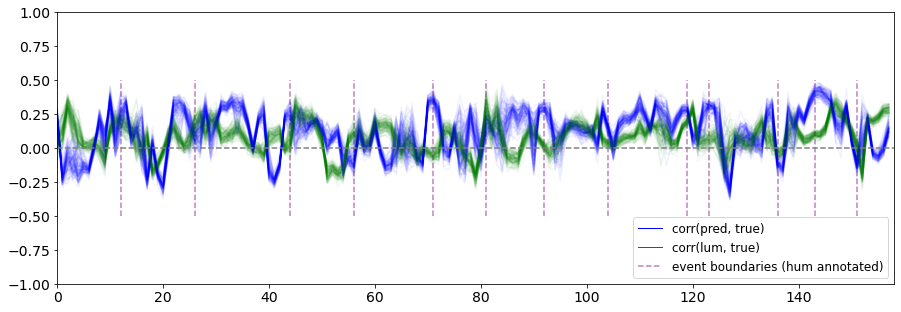

In [12]:
pc_pred_lum_timecourse(corr)

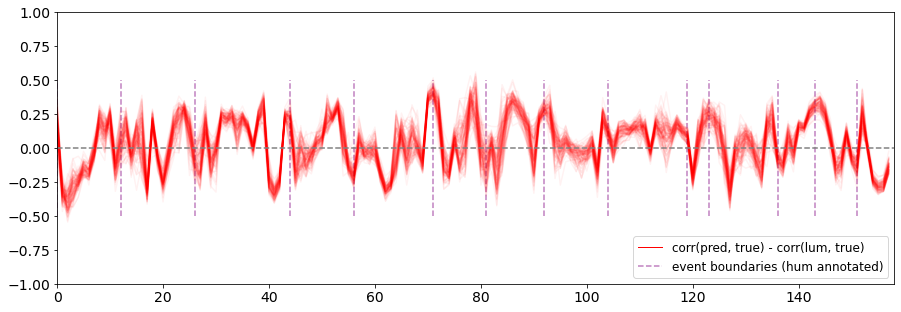

In [13]:
pc_difference_timecourse(corr)

#### Boundary triggered averages with bootstraps

In [14]:
bound_averages = generate_boundary_triggered_averages(corr)

Generating bootstrapped boundaries: 100%|██████████| 1000/1000 [00:10<00:00, 97.46it/s]


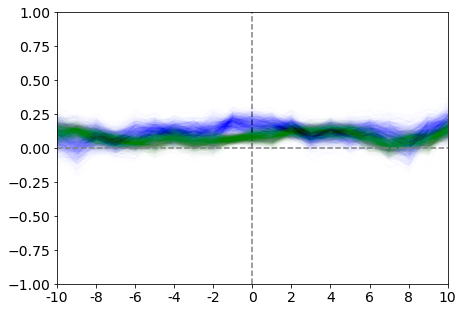

In [15]:
pc_bootstrapped_pred_lum(bound_averages)

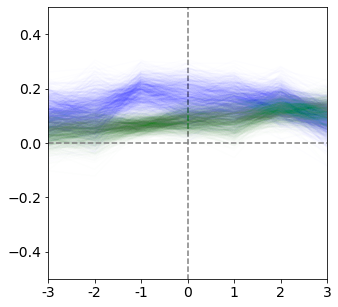

In [16]:
pc_bootstrapped_pred_lum_3TRs(bound_averages)

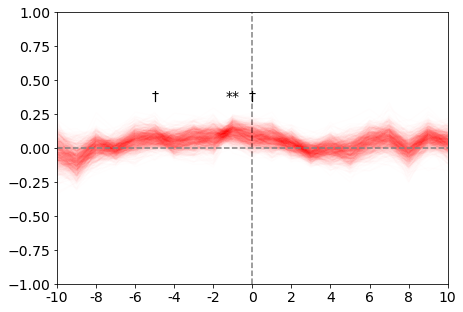

In [17]:
pc_bootstrapped_difference(bound_averages)

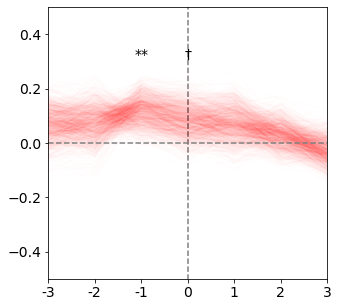

In [19]:
pc_bootstrapped_difference_3TRs(bound_averages)

## ±20 TRs

In [20]:
corr = generate_bootstrapped_correlations(true, pred, lum, TR_band=20)

Generating and loading bootstraps: 100%|██████████| 100/100 [05:42<00:00,  3.42s/it]


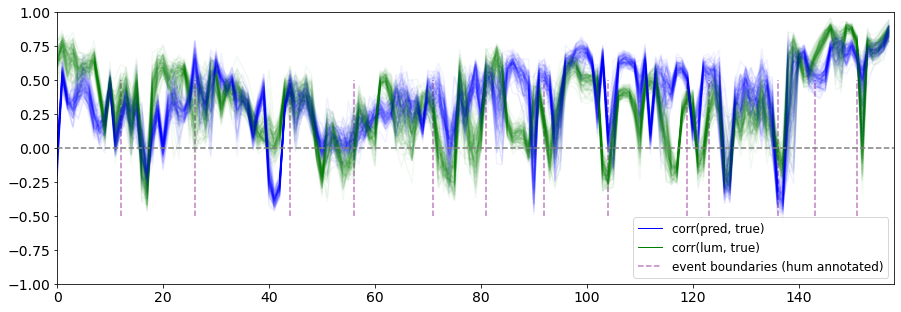

In [21]:
pc_pred_lum_timecourse(corr)

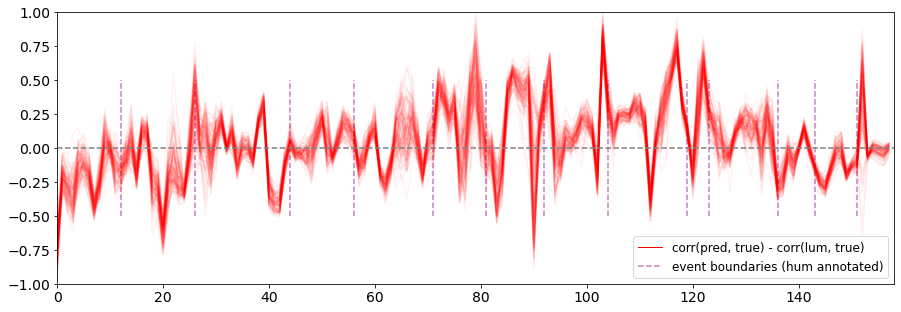

In [22]:
pc_difference_timecourse(corr)

## Boundary triggered averages

In [23]:
bound_averages = generate_boundary_triggered_averages(corr)

Generating bootstrapped boundaries: 100%|██████████| 1000/1000 [00:10<00:00, 97.01it/s]


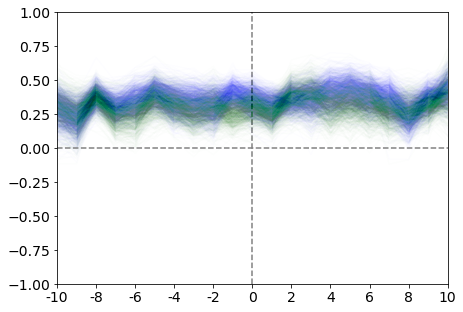

In [24]:
pc_bootstrapped_pred_lum(bound_averages)

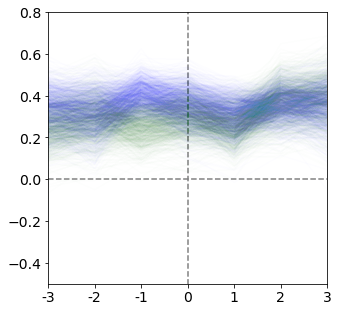

In [25]:
pc_bootstrapped_pred_lum_3TRs(bound_averages, y_max=0.8)

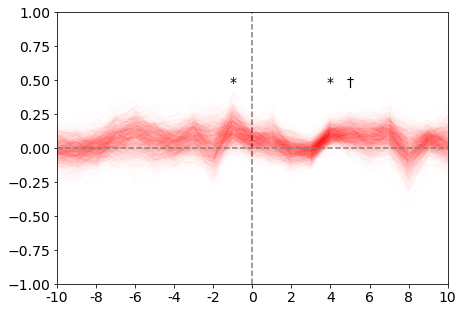

In [26]:
pc_bootstrapped_difference(bound_averages)

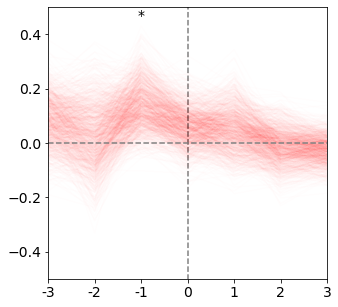

In [27]:
pc_bootstrapped_difference_3TRs(bound_averages)

In [174]:
bound_averages[0,10,:].mean() - bound_averages[1,10,:].mean()

0.06373751474987221

In [177]:
diffs = bound_averages[0,:,:] - bound_averages[1,:,:]
print(num_below_zero(diffs)[8:12])

[0.42357642 0.03096903 0.16483516 0.23276723]


### bandwidth testing

In [24]:
nTR = true.shape[0]
corr = np.zeros((2, nTR//2, nTR)) # pred,lum x band_width x corr(each_row) 
for b in range (1,nTR//2):
    upt = ~np.triu(np.ones(nTR).astype(bool), b + 1) # upper triangle of 0s
    lot = np.triu(np.ones(nTR).astype(bool), -b) # lower triangle of 0s
    band = upt & lot
    notdiag = 1-np.diag(np.ones(158)).astype(bool)
    band = band & notdiag
    band = band.astype(bool)

    for i in range(1, nTR-1):
        corr[0,b,i] = stats.pearsonr(pred[i][band[i]], true[i][band[i]])[0]
        corr[1,b,i] = stats.pearsonr(lum[i][band[i]], true[i][band[i]])[0]

mean_corr = np.zeros((2,nTR//2))
for b in range(1, nTR//2):
    mean_corr[0,b] = np.mean(corr[0,b,:])
    mean_corr[1,b] = np.mean(corr[1,b,:])

Text(0.5, 1.0, 'mean correlation of row x row corrs from TRxTR matrices')

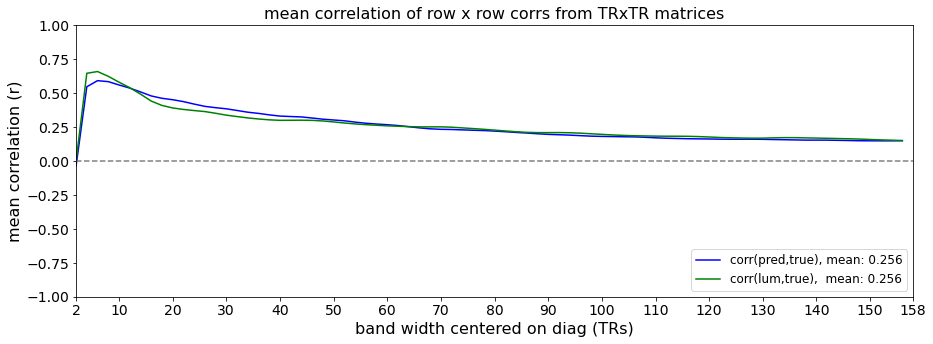

In [25]:
import matplotlib.ticker as ticker
plt.figure(figsize=(15, 5))
plt.tick_params(axis='x', top=False, labeltop=False)
plt.plot(mean_corr[0], color='blue', label=f'corr(pred,true), mean: {np.mean(corr[0]):.3f}')
plt.plot(mean_corr[1], color='green', label=f'corr(lum,true),  mean: {np.mean(corr[1]):.3f}')
axes = plt.gca()
axes.set_ylim([-1,1])
axes.set_xlim([1,nTR//2])
axes.set_ylabel("mean correlation (r)")
axes.set_xlabel("band width centered on diag (TRs)")

ticks = [i for i in np.concatenate(([2], np.arange(10,  nTR, step=10), [nTR]))/2]
ticklabels = [f'{i:.0f}' for i in np.concatenate(([2], np.arange(10,  nTR, step=10), [nTR]))]
axes.set_xticks(ticks)
axes.set_xticklabels(ticklabels)

plt.axhline(0, 0, nTR, linestyle='dashed', color='grey')
plt.legend(fontsize='large', loc='lower right')
plt.title("mean correlation of row x row corrs from TRxTR matrices")

### Mean diff in corr at lag 0 from bootstrapped boundary triggered averages with varied bandwidth

In [30]:
nTR = true.shape[0]
corr = np.zeros((2, nTR//2, nTR)) # pred,lum x band_width x corr(each_row) 

In [138]:
bound_averages.shape

(2, 21, 1000)

In [139]:
diffs = bound_averages[0,:,:] - bound_averages[1,:,:]
print(bound_averages[0,10,:].mean() - bound_averages[1,10,:].mean())

0.0837359437011153


In [155]:
diffs = bound_averages[0,:,:] - bound_averages[1,:,:]
print(bound_averages[0,10,:].mean() - bound_averages[1,10,:].mean())

0.07108476544847514


In [159]:
diffs.max()
num_below_zero(diffs)

array([0.48514851, 0.94059406, 0.57425743, 0.62376238, 0.16831683,
       0.07920792, 0.25742574, 0.16831683, 0.15841584, 0.01980198,
       0.08910891, 0.13861386, 0.2970297 , 0.71287129, 0.54455446,
       0.68316832, 0.26732673, 0.18811881, 0.69306931, 0.11881188,
       0.22772277])

In [180]:
bwidth_testing = np.zeros((2, nTR//2))
for b in range(1,nTR//2):
    if b % 5 == 0: print(f"Bandwidth: {b}")
    corr = generate_bootstrapped_correlations(true, pred, lum, TR_band=nTR, num_bootstraps=50)
    bound_averages = generate_boundary_triggered_averages(corr)
    diffs = bound_averages[0,:,:] - bound_averages[1,:,:]
    bwidth_testing[0,b] = bound_averages[0,10,:].mean() - bound_averages[1,10,:].mean()
    bwidth_testing[1,b] = num_below_zero(diffs)[10]

Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:05<00:00, 91.04it/s] 


Bandwidth: 5


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:05<00:00, 97.58it/s] 


Bandwidth: 10


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 105.30it/s]


Bandwidth: 15


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:05<00:00, 89.49it/s] 


Bandwidth: 20


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 107.55it/s]


Bandwidth: 25


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 104.57it/s]


Bandwidth: 30


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 102.54it/s]


Bandwidth: 35


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:05<00:00, 97.51it/s] 


Bandwidth: 40


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 101.92it/s]


Bandwidth: 45


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 105.11it/s]


Bandwidth: 50


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 104.39it/s]


Bandwidth: 55


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 103.76it/s]


Bandwidth: 60


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 102.15it/s]


Bandwidth: 65


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 104.56it/s]


Bandwidth: 70


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 101.75it/s]


Bandwidth: 75


Generating bootstrapped boundaries: 100%|██████████| 500/500 [00:04<00:00, 104.99it/s]


In [28]:
# np.save("bootstrap_bandwidth_testing_50x10.npy", bwidth_testing)
bwidth_testing = np.load("bootstrap_bandwidth_testing_50x10.npy", allow_pickle=True)

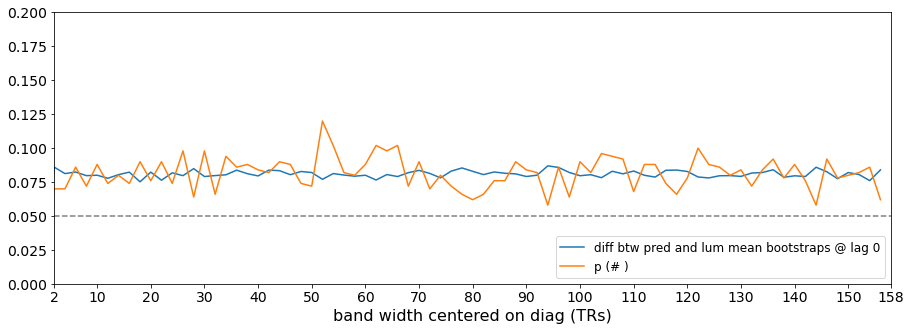

In [31]:
plt.figure(figsize=(15, 5))
plt.tick_params(axis='x', top=False, labeltop=False)
plt.plot(bwidth_testing[0], label='diff btw pred and lum mean bootstraps @ lag 0')
plt.plot(bwidth_testing[1], label='p (# )')
# plt.plot(mean_corr[0], color='blue', label=f'corr(pred,true), mean: {np.mean(corr[0]):.3f}')
# plt.plot(mean_corr[1], color='green', label=f'corr(lum,true),  mean: {np.mean(corr[1]):.3f}')
axes = plt.gca()
axes.set_ylim([0,.2])
axes.set_xlim([1,nTR//2])
# axes.set_ylabel("mean correlation (r)")
axes.set_xlabel("band width centered on diag (TRs)")

ticks = [i for i in np.concatenate(([2], np.arange(10,  nTR, step=10), [nTR]))/2]
ticklabels = [f'{i:.0f}' for i in np.concatenate(([2], np.arange(10,  nTR, step=10), [nTR]))]
axes.set_xticks(ticks)
axes.set_xticklabels(ticklabels)

plt.axhline(0.05, 0, nTR, linestyle='dashed', color='grey')
plt.legend(fontsize='large', loc='lower right')
# plt.title("mean correlation of row x row corrs from TRxTR matrices")

In [154]:
bwidth_testing

array([[0.        , 0.07945847, 0.06348881, 0.06112204, 0.07080591,
        0.07088384, 0.08647137, 0.07300087, 0.07345508, 0.06243974,
        0.0871685 , 0.07946175, 0.0714234 , 0.06405961, 0.07684834,
        0.07328313, 0.07239477, 0.07072836, 0.07992342, 0.07475752,
        0.06560567, 0.08011072, 0.07614242, 0.07093257, 0.06390238,
        0.06881017, 0.0780156 , 0.06967829, 0.06987004, 0.06393592,
        0.07634868, 0.07038174, 0.07267021, 0.07653311, 0.07836448,
        0.0701291 , 0.06142477, 0.07828269, 0.07836421, 0.07413744,
        0.0742171 , 0.08203287, 0.07620066, 0.08576999, 0.08209251,
        0.07143103, 0.0689426 , 0.0766482 , 0.07364399, 0.07571345,
        0.08205459, 0.0646138 , 0.0728348 , 0.06970536, 0.07763243,
        0.07270388, 0.0755572 , 0.07697578, 0.06993001, 0.08431671,
        0.07428636, 0.08127116, 0.07602747, 0.07071903, 0.06664045,
        0.08475186, 0.07207808, 0.0790205 , 0.07535618, 0.07841661,
        0.07044056, 0.07590813, 0.07562947, 0.07

#### Notes
- rewrite check for file suffix to be fn with list from beginning?

## Appendix

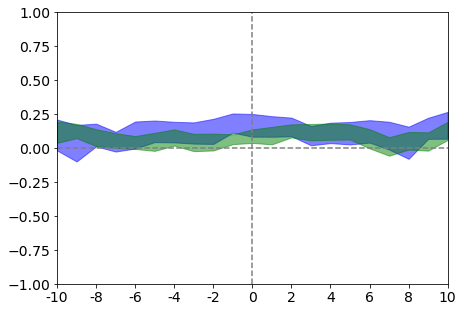

In [38]:
imgtofmri.pc_bootstrapped_pred_lum_conf_intervals(bound_averages)

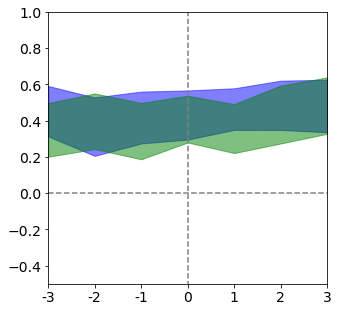

In [33]:
imgtofmri.pc_bootstrapped_pred_lum_3TRs_conf_intervals(bound_averages)

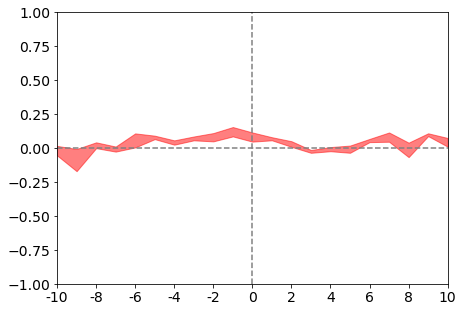

In [45]:
imgtofmri.pc_bootstrapped_difference_conf_intervals(bound_averages)

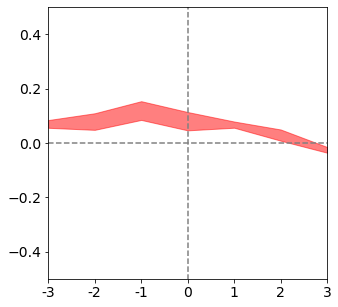

In [46]:
imgtofmri.pc_bootstrapped_difference_3TRs_conf_intervals(bound_averages)